# CITS5017 Project 1
Kaylee Molin (22734429)

September 2023

---

### Importing Relevant Packages

In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical # FIX ask if this is allowed
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier # for hyperparam tuning only
from tensorflow.keras.optimizers import SGD

### Loading dataset

In [2]:
(X_train_original, y_train_original), (X_test_original, y_test_original) = tf.keras.datasets.cifar10.load_data()
assert X_train_original.shape == (50000, 32, 32, 3)
assert X_test_original.shape == (10000, 32, 32, 3)
assert y_train_original.shape == (50000, 1)
assert y_test_original.shape == (10000, 1)

### Normalising the pixel values to be between 0 and 1

In [3]:
X_train_norm, X_test = X_train_original/255.0, X_test_original/255.0
y_test=y_test_original

### (i) Forming a validation set form the training set

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X_train_norm, y_train_original, test_size=0.15, random_state=22, stratify=y_train_original)
# Print the shapes of the resulting datasets
print("Training set shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("\nValidation set shapes:")
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)
print("\nTest set shapes:")
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Training set shapes:
X_train: (42500, 32, 32, 3)
y_train: (42500, 1)

Validation set shapes:
X_val: (7500, 32, 32, 3)
y_val: (7500, 1)

Test set shapes:
X_test: (10000, 32, 32, 3)
y_test: (10000, 1)


### (ii) Function to display 20 randomly sampled images

In [5]:
def display_random_subset(X, y, class_names, title):
    plt.figure(figsize=(12, 6))
    indices = np.random.randint(0, len(X), size=20)
    
    for i, index in enumerate(indices):
        plt.subplot(4, 5, i+1)
        plt.imshow(X[index])
        plt.title(class_names[y[index][0]])
        plt.axis('off')
    
    plt.suptitle(title, fontsize=16)  # Adding a title to the entire figure
    plt.subplots_adjust(wspace=0.2, hspace=0.4)  # Adjusting the horizontal and vertical space
    #plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjusting layout for the title
    plt.show()


In [6]:
# Load class names from TFDS
dataset_info = tfds.builder("cifar10")
class_names = dataset_info.info.features["label"].names

2023-09-02 19:28:17.284575: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


### Displaying 20 random images from the training set

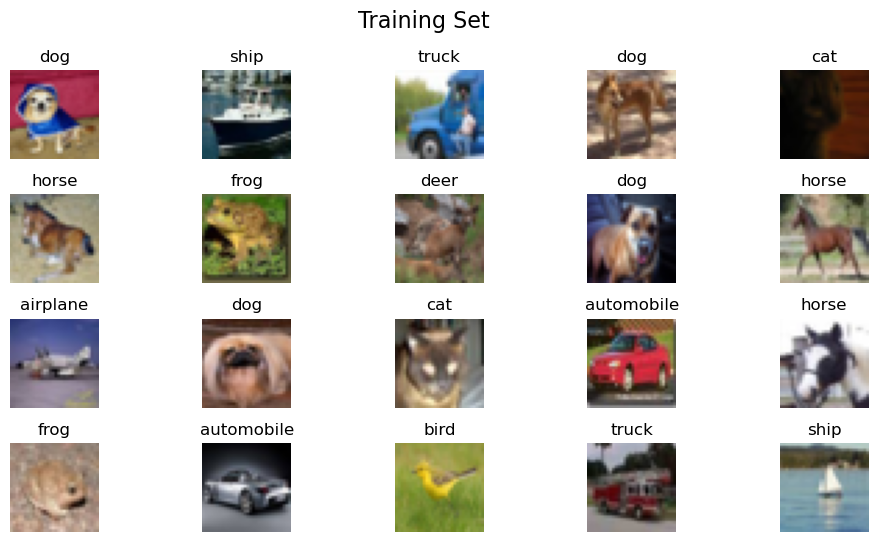

In [7]:
display_random_subset(X_train, y_train, class_names, "Training Set")

### Displaying 20 random images from the validation set

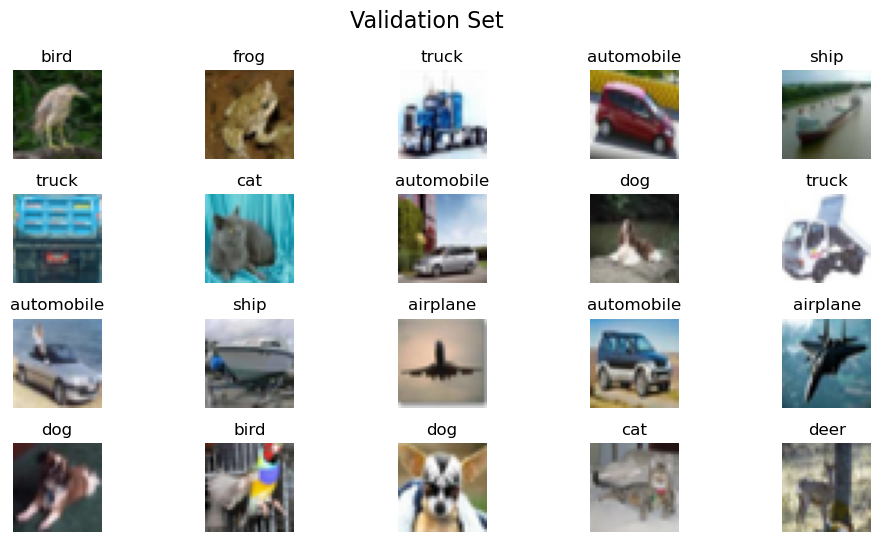

In [8]:
display_random_subset(X_val, y_val, class_names, "Validation Set")

### Displaying 20 random images from the testing set

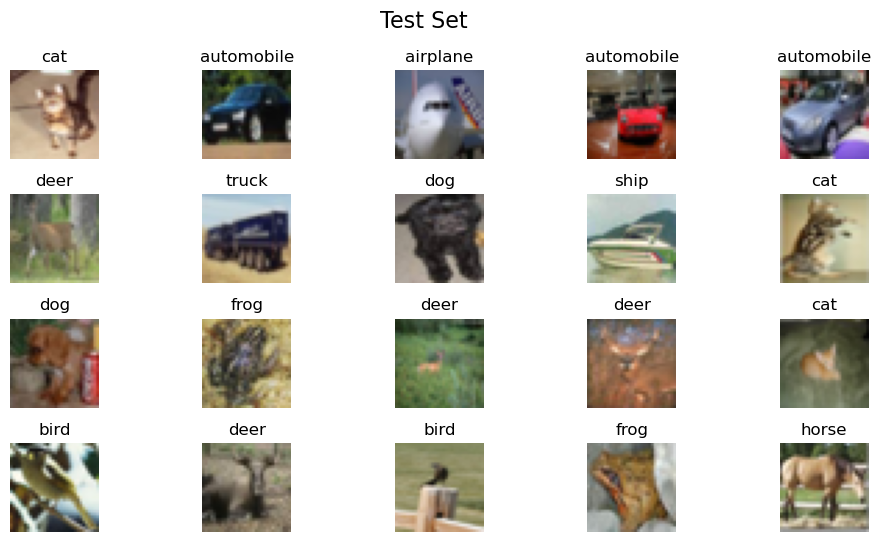

In [9]:
display_random_subset(X_test, y_test, class_names, "Test Set")

In [10]:
# ds, ds_info = tfds.load('cifar10', split='train', with_info=True)
# fig = tfds.show_examples(ds, ds_info)

In [11]:
# Get the number of classes
num_classes = len(class_names)

# y_train = to_categorical(y_train, num_classes)
# y_val = to_categorical(y_val, num_classes)
# y_test = to_categorical(y_test, num_classes)

In [12]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape


((42500, 32, 32, 3), (10000, 32, 32, 3), (42500, 1), (10000, 1))

### (iii) Training an MLP

In [13]:
# new architecture 02/09

def create_mlp_model(learning_rate=0.01, weight_initializer='glorot_uniform', dropout_rate=0.2):
    model = Sequential([
        Flatten(input_shape=(32, 32, 3)),
        Dense(512, activation='relu'),
        Dropout(dropout_rate),  # Use the dropout_rate parameter here
        Dense(256, activation='relu'),
        Dropout(dropout_rate),  # Use the dropout_rate parameter here
        Dense(num_classes, activation='softmax')
    ])

    optimizer = SGD(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [14]:
mlp_model = KerasClassifier(build_fn=create_mlp_model)
mlp_param = dict(kernel_initializer=['he_uniform','glorot_uniform'],
                learning_rate=[0.01,0.1],
                dropout_rate = [0.2, 0.3])

mlp_grid = GridSearchCV(estimator=mlp_model, param_grid=mlp_param, n_jobs=-1,cv=3)
grid_result = mlp_grid.fit(X_val,y_val,epochs=100)
grid_result.best_params_

ValueError: Invalid parameter dropout_rate for estimator KerasClassifier.
This issue can likely be resolved by setting this parameter in the KerasClassifier constructor:
`KerasClassifier(dropout_rate=0.2)`
Check the list of available parameters with `estimator.get_params().keys()`

In [ ]:
# Get the number of classes
# num_classes = len(class_names)

# Create the MLP model
model_mlp = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[32, 32, 3]),
    #tf.keras.layers.Dense(1024, activation='relu'),  
    tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.2),  # Use the dropout_rate parameter here
    # tf.keras.layers.Dense(1000, activation='relu'),   
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.2),  # Use the dropout_rate parameter here
    tf.keras.layers.Dense(num_classes, activation='softmax')  # Output layer with num_classes units and softmax activation
])

# optimizer=tf.keras.optimizers.legacy.Adam()
optimizer = SGD(learning_rate=0.1)

# Compile the model
model_mlp.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Defining the early stopping callback
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model_mlp.fit(X_train, y_train, epochs=100,batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])

model_mlp.summary()


# https://github.com/adameksopot/MLP-for-Cifar10-/blob/master/MLP.ipynb
# try this! very good accuracy

In [16]:
# Hyperparameters to experiment with
weight_initializations = ['glorot_uniform', 'he_normal'] # read https://keras.io/api/layers/initializers/ for more initialisers
dropout_rates = [0.2, 0.4]
input_shape=(32, 32, 3)

for weight_init in weight_initializations:
    for dropout_rate in dropout_rates:

        print("Weight initialisation: {}".format(weight_init))
        print("Dropout rate: {}".format(dropout_rate))
        # Create the MLP model with hyperparameters
        model = Sequential([
            Flatten(input_shape=input_shape),
            Dense(512, activation='relu', kernel_initializer=weight_init),
            Dropout(dropout_rate),
            Dense(256, activation='relu', kernel_initializer=weight_init),
            Dropout(dropout_rate),
            Dense(num_classes, activation='softmax')
        ])

        # Compile the model
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

        # Define early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        # Train the model with early stopping on the validation set
        history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

        # Evaluate the model on the test set
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
        
        # Print results for each combination of hyperparameters
        print(f"Weight Init: {weight_init}, Dropout Rate: {dropout_rate}")
        print("Test accuracy:", test_accuracy)
        print("-" * 40)

2023-09-02 19:31:04.348131: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-09-02 19:31:04.348174: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-09-02 19:31:04.348184: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-09-02 19:31:04.348218: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-02 19:31:04.348238: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2023-09-02 19:31:06.824591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - ETA: 0s - loss: 4.7608 - accuracy: 0.1862

2023-09-02 19:31:20.924318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - 16s 11ms/step - loss: 4.7608 - accuracy: 0.1862 - val_loss: 4.6499 - val_accuracy: 0.1959
Epoch 2/100
1329/1329 [==============================] - 16s 12ms/step - loss: 3.8441 - accuracy: 0.2136 - val_loss: 5.4575 - val_accuracy: 0.1672
Epoch 3/100
1329/1329 [==============================] - 14s 10ms/step - loss: 4.3862 - accuracy: 0.2052 - val_loss: 13.0701 - val_accuracy: 0.1001
Epoch 4/100
1329/1329 [==============================] - 14s 10ms/step - loss: 5.7749 - accuracy: 0.1971 - val_loss: 7.9019 - val_accuracy: 0.1620
Epoch 5/100
1329/1329 [==============================] - 20s 15ms/step - loss: 6.5631 - accuracy: 0.1956 - val_loss: 14.2376 - val_accuracy: 0.1391
Epoch 6/100
1329/1329 [==============================] - 27s 20ms/step - loss: 7.6276 - accuracy: 0.1876 - val_loss: 20.5733 - val_accuracy: 0.1003
Epoch 7/100
1329/1329 [==============================] - 19s 15ms/step - loss: 7.9206 - accuracy: 0.1900 - val_loss: 16.9069 - 

Weight Init: glorot_uniform, Dropout Rate: 0.2
Test accuracy: 0.19370000064373016
----------------------------------------
Epoch 1/100


2023-09-02 19:34:19.900108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - ETA: 0s - loss: 6.0853 - accuracy: 0.1648

2023-09-02 19:34:33.070139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - 14s 11ms/step - loss: 6.0853 - accuracy: 0.1648 - val_loss: 6.2577 - val_accuracy: 0.1253
Epoch 2/100
1329/1329 [==============================] - 14s 10ms/step - loss: 5.0691 - accuracy: 0.1867 - val_loss: 8.0524 - val_accuracy: 0.1637
Epoch 3/100
1329/1329 [==============================] - 15s 11ms/step - loss: 6.0958 - accuracy: 0.1900 - val_loss: 5.9266 - val_accuracy: 0.1960
Epoch 4/100
1329/1329 [==============================] - 15s 11ms/step - loss: 6.7199 - accuracy: 0.1881 - val_loss: 10.9303 - val_accuracy: 0.1548
Epoch 5/100
1329/1329 [==============================] - 14s 10ms/step - loss: 7.3511 - accuracy: 0.1867 - val_loss: 8.7114 - val_accuracy: 0.1733
Epoch 6/100
1329/1329 [==============================] - 14s 10ms/step - loss: 8.2038 - accuracy: 0.1846 - val_loss: 15.6346 - val_accuracy: 0.1239
Epoch 7/100
1329/1329 [==============================] - 14s 10ms/step - loss: 9.0844 - accuracy: 0.1820 - val_loss: 15.2112 - v

Weight Init: glorot_uniform, Dropout Rate: 0.4
Test accuracy: 0.1940000057220459
----------------------------------------
Epoch 1/100
   1/1329 [..............................] - ETA: 8:57 - loss: 3.4005 - accuracy: 0.0312

2023-09-02 19:37:31.143982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - ETA: 0s - loss: 5.1060 - accuracy: 0.1904

2023-09-02 19:37:44.761010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - 15s 11ms/step - loss: 5.1060 - accuracy: 0.1904 - val_loss: 6.3735 - val_accuracy: 0.1661
Epoch 2/100
1329/1329 [==============================] - 14s 11ms/step - loss: 4.5720 - accuracy: 0.2082 - val_loss: 7.7834 - val_accuracy: 0.1572
Epoch 3/100
1329/1329 [==============================] - 14s 11ms/step - loss: 5.3918 - accuracy: 0.2027 - val_loss: 4.6958 - val_accuracy: 0.2349
Epoch 4/100
1329/1329 [==============================] - 14s 11ms/step - loss: 6.4625 - accuracy: 0.1984 - val_loss: 3.9726 - val_accuracy: 0.2607
Epoch 5/100
1329/1329 [==============================] - 14s 10ms/step - loss: 7.7313 - accuracy: 0.1923 - val_loss: 17.2881 - val_accuracy: 0.1915
Epoch 6/100
1329/1329 [==============================] - 14s 10ms/step - loss: 9.5844 - accuracy: 0.1885 - val_loss: 15.6472 - val_accuracy: 0.1289
Epoch 7/100
1329/1329 [==============================] - 15s 11ms/step - loss: 12.2030 - accuracy: 0.1851 - val_loss: 10.6311 - 

Weight Init: he_normal, Dropout Rate: 0.2
Test accuracy: 0.2574999928474426
----------------------------------------
Epoch 1/100


2023-09-02 19:40:52.772452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - ETA: 0s - loss: 6.7918 - accuracy: 0.1716

2023-09-02 19:41:07.189890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - 16s 12ms/step - loss: 6.7918 - accuracy: 0.1716 - val_loss: 10.7322 - val_accuracy: 0.1531
Epoch 2/100
1329/1329 [==============================] - 14s 11ms/step - loss: 5.7025 - accuracy: 0.1931 - val_loss: 10.2052 - val_accuracy: 0.1949
Epoch 3/100
1329/1329 [==============================] - 14s 10ms/step - loss: 7.2236 - accuracy: 0.1865 - val_loss: 10.8180 - val_accuracy: 0.2077
Epoch 4/100
1329/1329 [==============================] - 14s 11ms/step - loss: 9.0658 - accuracy: 0.1807 - val_loss: 26.3929 - val_accuracy: 0.1076
Epoch 5/100
1329/1329 [==============================] - 14s 11ms/step - loss: 10.3540 - accuracy: 0.1815 - val_loss: 23.4556 - val_accuracy: 0.1567
Epoch 6/100
1329/1329 [==============================] - 14s 10ms/step - loss: 11.3633 - accuracy: 0.1808 - val_loss: 21.3570 - val_accuracy: 0.1629
Epoch 7/100
1329/1329 [==============================] - 14s 10ms/step - loss: 11.8110 - accuracy: 0.1825 - val_loss: 27.8

## CNN

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization

num_classes = 10
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 64
epochs = 10
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_val, y_val, verbose=2)
print("\nTest accuracy:", test_accuracy)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 15, 15, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                      

2023-09-02 19:47:15.633188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


665/665 [==============================] - ETA: 0s - loss: 1.4484 - accuracy: 0.4880

2023-09-02 19:47:28.960887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


665/665 [==============================] - 15s 20ms/step - loss: 1.4484 - accuracy: 0.4880 - val_loss: 1.4722 - val_accuracy: 0.5025
Epoch 2/10
665/665 [==============================] - 12s 18ms/step - loss: 1.1701 - accuracy: 0.5905 - val_loss: 1.6361 - val_accuracy: 0.4920
Epoch 3/10
665/665 [==============================] - 12s 18ms/step - loss: 1.1034 - accuracy: 0.6169 - val_loss: 2.0304 - val_accuracy: 0.4539
Epoch 4/10
665/665 [==============================] - 12s 18ms/step - loss: 1.1258 - accuracy: 0.6123 - val_loss: 1.5425 - val_accuracy: 0.5203
Epoch 5/10
665/665 [==============================] - 12s 19ms/step - loss: 1.1644 - accuracy: 0.6073 - val_loss: 2.0303 - val_accuracy: 0.5040
Epoch 6/10
665/665 [==============================] - 14s 20ms/step - loss: 1.2480 - accuracy: 0.5910 - val_loss: 1.8043 - val_accuracy: 0.5108
Epoch 7/10
665/665 [==============================] - 13s 20ms/step - loss: 1.3244 - accuracy: 0.5826 - val_loss: 2.5781 - val_accuracy: 0.4075
Epo